# transactions.csv

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import mpld3 as mpld3
from ggplot import *
import seaborn as sns
import time
from datetime import datetime
from collections import Counter
from pandas.lib import Timestamp
from pandas.core import datetools
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestRegressor

/Users/pablodepaz/anaconda3/lib/python3.6/site-packages/ggplot/utils.py:81: FutureWarning: pandas.tslib is deprecated and will be removed in a future version.
You can access Timestamp as pandas.Timestamp
  pd.tslib.Timestamp,
/Users/pablodepaz/anaconda3/lib/python3.6/site-packages/ggplot/stats/smoothers.py:4: FutureWarning: The pandas.lib module is deprecated and will be removed in a future version. These are private functions and can be accessed from pandas._libs.lib instead
  from pandas.lib import Timestamp
/Users/pablodepaz/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Loading 1M samples of the data in a random way

In [2]:
url_trans = "data/transactions_v2.csv"
#trans_data = pd.read_csv(url_trans)
trans_data = pd.read_csv(url_trans)
#nlinesfile = 21547746
#nlinesrandomsample = 1000000
#lines2skip = np.random.choice(np.arange(1,nlinesfile+1), (nlinesfile-nlinesrandomsample), replace = False)
#trans_data = pd.read_csv(url_trans, skiprows = lines2skip)

## 1. Get some insights of the dataset

In [3]:
#Summary of the data
print(trans_data.shape)
print(trans_data.info())
print(trans_data.describe())

(1431009, 9)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1431009 entries, 0 to 1431008
Data columns (total 9 columns):
msno                      1431009 non-null object
payment_method_id         1431009 non-null int64
payment_plan_days         1431009 non-null int64
plan_list_price           1431009 non-null int64
actual_amount_paid        1431009 non-null int64
is_auto_renew             1431009 non-null int64
transaction_date          1431009 non-null int64
membership_expire_date    1431009 non-null int64
is_cancel                 1431009 non-null int64
dtypes: int64(8), object(1)
memory usage: 98.3+ MB
None
       payment_method_id  payment_plan_days  plan_list_price  \
count       1.431009e+06       1.431009e+06     1.431009e+06   
mean        3.791835e+01       6.601770e+01     2.817870e+02   
std         4.964805e+00       1.024864e+02     4.351861e+02   
min         2.000000e+00       0.000000e+00     0.000000e+00   
25%         3.600000e+01       3.000000e+01     9.900000e

We have 8 features (in addition to the ID, "msno"). I can draw the following conclusions:
- All features are of type Integer with 64 bits except the ID (msno), that is an object.
- payment_method_id is encoded in integer from [1,41]. The most common value is 41.
- payment_plan_days measures the length of membership subscription in days. Typically, a user would subscribe 30 days (and then re-subscribe, automanically or manually). Values are [0, 450], being 30 the most popular.
- plan_list_price and actual_amount_paid shows the theoretical and actual subscription price in units of New Taiwan Dollar (NTD). Values range [0, 2000]. Mean is a bit higher in _list_ than in _actual_ paid. Maybe this is because some promotions or problems with payment.
- is_auto_renew is binary: 0 or 1. It shows if transaction was automatically renewed. Mean is 0.85 so most of the user chose this option.
- transaction_date and membership_expire_date are the KEY FEATURES to determine if an user has churned. Definition can be seen below.
- is_cancel shows if an user cancels a transaction. Could lead to churn.

### Churn: "no new valid service subscription within 30 days after the current membership expires"

In [4]:
trans_data.head()

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel
0,++6eU4LsQ3UQ20ILS7d99XK8WbiVgbyYL4FUgzZR134=,32,90,298,298,0,20170131,20170504,0
1,++lvGPJOinuin/8esghpnqdljm6NXS8m8Zwchc7gOeA=,41,30,149,149,1,20150809,20190412,0
2,+/GXNtXWQVfKrEDqYAzcSw2xSPYMKWNj22m+5XkVQZc=,36,30,180,180,1,20170303,20170422,0
3,+/w1UrZwyka4C9oNH3+Q8fUf3fD8R3EwWrx57ODIsqk=,36,30,180,180,1,20170329,20170331,1
4,+00PGzKTYqtnb65mPKPyeHXcZEwqiEzktpQksaaSC3c=,41,30,99,99,1,20170323,20170423,0


### 1.1 Payment Method ID

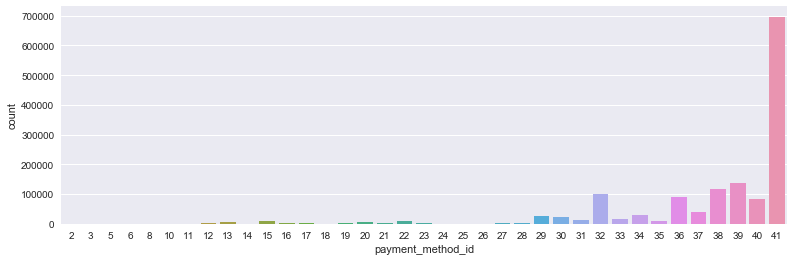

In [5]:
# Features visualization
mpld3.enable_notebook()

sns.set(rc={'figure.figsize':(13,4)}) #Horizontal, vertical
sns.countplot(x='payment_method_id', data=trans_data)

Payment Method 41 is the most popular one.
In addition, methods above 30 are used by a noticeable amount of users.

### 1.2 Payment plan duration (in days)
Length of membership subscription in days

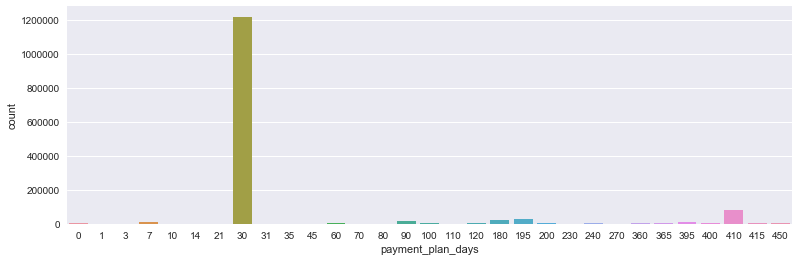

In [6]:
#trans_data.hist(column='payment_plan_days', bins=100, facecolor='r') #plt.ylabel('Nº of samples') #plt.xlabel('Nº of days') #plt.title('Payment Plan Duration')

sns.set(rc={'figure.figsize':(13,4)}) #Horizontal, vertical
sns.countplot(x='payment_plan_days',data=trans_data)

Most of the users' plan is 30 days. Even though, some values in 0, 7 and 31 days can be observed (between others).

### 1.3 Plan Price and Amount Paid
Shows the theoretical and actual subscription price in units of New Taiwan Dollar (NTD). 
Mean is a bit higher in list than in actual paid. Maybe this is because some promotions or problems with payment.

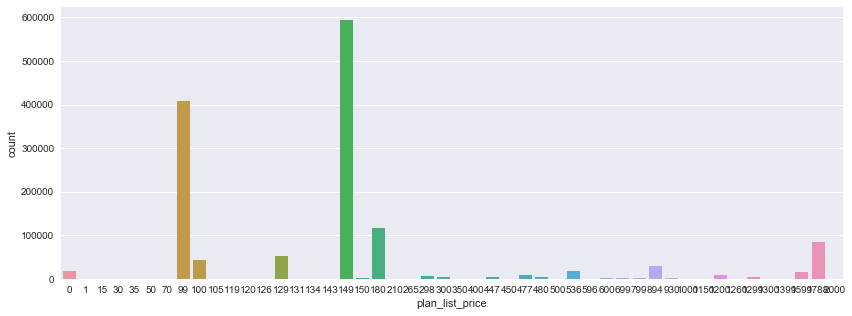

In [7]:
sns.set(rc={'figure.figsize':(14,5)}) #Horizontal, vertical
sns.countplot(x='plan_list_price',data=trans_data)

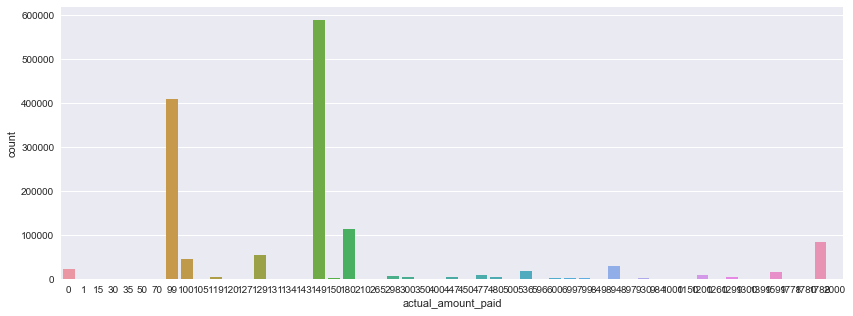

In [8]:
sns.set(rc={'figure.figsize':(14,5)}) #Horizontal, vertical
sns.countplot(x='actual_amount_paid',data=trans_data)

Overall distributions are very similar. Still, some differences are visible such as for 119 NTD.
We can compare their frequency as they are discrete values.

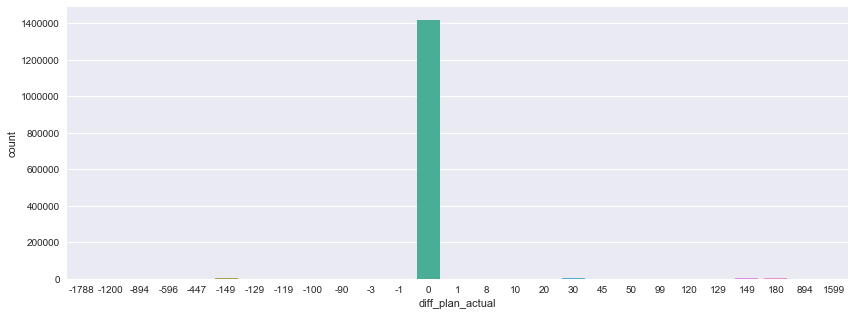

In [9]:
trans_data['diff_plan_actual'] = trans_data['plan_list_price'] - trans_data['actual_amount_paid']
sns.set(rc={'figure.figsize':(14,5)}) #Horizontal, vertical
sns.countplot(x='diff_plan_actual',data=trans_data)

(1419106, 10)


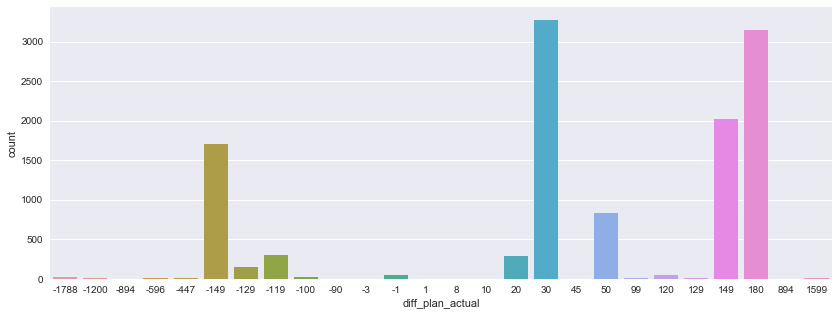

In [10]:
print(trans_data[trans_data.diff_plan_actual == 0].shape)

diff_plan_actual_var = trans_data[trans_data.diff_plan_actual != 0]
sns.set(rc={'figure.figsize':(14,5)}) #Horizontal, vertical
sns.countplot(x='diff_plan_actual', data=diff_plan_actual_var)

It can be observed that most of the people paid (as 0 is very large) but there are some mismatches for individual users.
Interestingly, in some cases, the users end up paying more (positive values). This can be better seen in the 2nd graph where "0" values have been taken away.

In [11]:
trans_data['plan_list_price'].corr(trans_data['actual_amount_paid'],method='pearson')    

0.9994581971674552

##### Around 920K values are zero, which means that correlation between these 2 features is around 92%.

### 1.3.bis. Conver to datetime object to be used later.

In [12]:
trans_data['transaction_date'] = trans_data.transaction_date.apply(lambda x: datetime.strptime(str(int(x)), "%Y%m%d").date())
trans_data['membership_expire_date'] = trans_data.membership_expire_date.apply(lambda x: datetime.strptime(str(int(x)), "%Y%m%d").date())
trans_data.head()

#trans_data['transaction_date_new'] = pd.to_datetime(trans_data['transaction_date'].astype(str), format='%Y%m%d')
#trans_data['membership_expire_date_new'] = pd.to_datetime(trans_data['membership_expire_date'].astype(str), format='%Y%m%d')
#print(trans_data.info())

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,diff_plan_actual
0,++6eU4LsQ3UQ20ILS7d99XK8WbiVgbyYL4FUgzZR134=,32,90,298,298,0,2017-01-31,2017-05-04,0,0
1,++lvGPJOinuin/8esghpnqdljm6NXS8m8Zwchc7gOeA=,41,30,149,149,1,2015-08-09,2019-04-12,0,0
2,+/GXNtXWQVfKrEDqYAzcSw2xSPYMKWNj22m+5XkVQZc=,36,30,180,180,1,2017-03-03,2017-04-22,0,0
3,+/w1UrZwyka4C9oNH3+Q8fUf3fD8R3EwWrx57ODIsqk=,36,30,180,180,1,2017-03-29,2017-03-31,1,0
4,+00PGzKTYqtnb65mPKPyeHXcZEwqiEzktpQksaaSC3c=,41,30,99,99,1,2017-03-23,2017-04-23,0,0


In [13]:
#sns.tsplot(data=trans_data., time="timepoint", unit="day")

### 1.4. Auto renew subscription
It shows if transaction was automatically renewed (if 1). 
Most of the users choose this option (automatic renewal).

is_auto_renew Count [(1, 1123775), (0, 307234)]


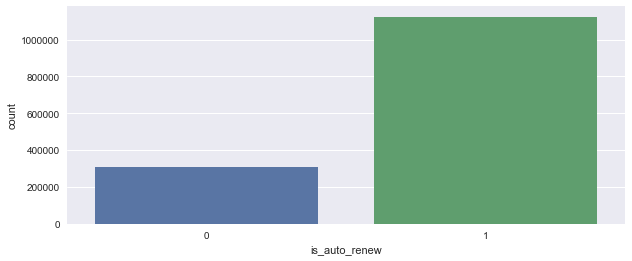

In [14]:
sns.set(rc={'figure.figsize':(10,4)}) #Horizontal, vertical
sns.countplot(x='is_auto_renew',data=trans_data)
is_auto_renew_count = Counter(trans_data['is_auto_renew']).most_common()
print("is_auto_renew Count " +str(is_auto_renew_count))

Around 82% of the users choose "auto_renew"!

### 1.6. Is Cancel
Show if a user cancel a transaction. If so, this is more likely to churn. Most of then, do NOT cancel.

is_cancel Count [(0, 1395876), (1, 35133)]


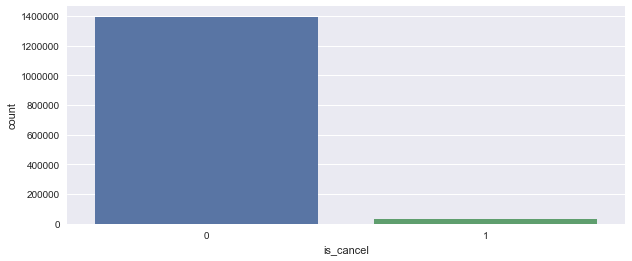

In [15]:
sns.set(rc={'figure.figsize':(10,4)}) #Horizontal, vertical
sns.countplot(x='is_cancel',data=trans_data)
is_cancel_count = Counter(trans_data['is_cancel']).most_common()
print("is_cancel Count " +str(is_cancel_count))

Only 4% of the users have canceled the subscription during the plan period.

### 1.7. Check missing values in the features

In [16]:
trans_data.apply(lambda x: sum(x.isnull()),axis=0) 

msno                      0
payment_method_id         0
payment_plan_days         0
plan_list_price           0
actual_amount_paid        0
is_auto_renew             0
transaction_date          0
membership_expire_date    0
is_cancel                 0
diff_plan_actual          0
dtype: int64

As there are not missing values, go on. This is OK.

### 1.8. Check whether "msno" are unique in the dataset

In [17]:
(trans_data['msno'].value_counts().reset_index())['msno'].value_counts()
#print(trans_data['msno'].value_counts()) Around 70K different users

1      1054810
2       121688
3        10885
4         2108
5         1609
6          920
7          622
8          465
9          379
11         373
10         299
13         294
12         293
21         280
14         273
15         213
16         159
20         155
17         125
19         116
22         108
23          88
24          71
18          67
25          61
36          59
35          50
28          46
29          46
27          43
        ...   
38          17
48           8
45           8
39           8
46           5
47           3
40           2
41           2
44           2
89           2
63           2
148          1
145          1
70           1
131          1
117          1
104          1
78           1
76           1
54           1
65           1
61           1
58           1
57           1
56           1
172          1
49           1
43           1
42           1
208          1
Name: msno, Length: 67, dtype: int64

I DON'T UNDERSTAND WHAT IT SHOWS.
Anyway, there are more than one entry for many users. 
Let's see one such user with 8 entries.

In [18]:
tmp1=trans_data['msno'].value_counts() 
tmp2=tmp1[tmp1==8]
print(tmp2.head(1))
del tmp1, tmp2

dGVh2tyYfm+7yLlLUxJH5EX7PJq7Ux1Tb966uPNqQIU=    8
Name: msno, dtype: int64


This user has 8 entries:
#### s3HJvAZ6D1pXY4CITf/3BJko+mBmEnCS8KRjLovVw1c=
Let's see its transaction details...

In [19]:
tmp1=trans_data[trans_data.msno=="s3HJvAZ6D1pXY4CITf/3BJko+mBmEnCS8KRjLovVw1c="]
tmp1=tmp1.sort_values('transaction_date')
tmp1

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,diff_plan_actual
528557,s3HJvAZ6D1pXY4CITf/3BJko+mBmEnCS8KRjLovVw1c=,41,30,129,129,1,2017-03-07,2017-04-07,0,0


The same user can have different "payment plan duration" with different "subscription time".
He had the 149 plan (but paid 119 maybe due to some discount). Then passed to the 129 plan. Finally, he passed to 149 plan again. And finally, to the 129 plan.

In [20]:
del tmp1 #memory cleaning

## 2. Treat extreme values

### 2.1. Payment Method ID
I just take values above 30.

In [21]:
#trans_data['payment_method_id'].value_counts()
trans_data[trans_data.payment_method_id <= 29]
print(trans_data[trans_data.payment_method_id <= 29].shape)

(75979, 10)


Approximately, there are around 8000 values that are below 25.

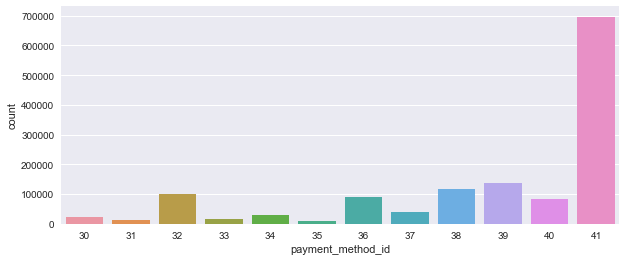

In [22]:
#trans_data[trans_data.payment_method_id <= 25] = trans_data['payment_method_id'].mean() 
#trans_data[trans_data.payment_method_id <= 25] = 39 
#trans_data.hist(column='payment_method_id', bins=80, facecolor='b')
#plt.ylabel('Nº of samples')
#plt.title('Payment Method ID')
# print(trans_data.payment_method_id.describe())

payment_method_id_var = trans_data[trans_data.payment_method_id > 29]
sns.countplot(x='payment_method_id',data=payment_method_id_var)

### 2.2 Payment plan days
I only take values below 90.

In [23]:
trans_data[trans_data.payment_plan_days >= 45]
print(trans_data[trans_data.payment_plan_days >= 45].shape)

(197398, 10)


Approximately, there are around 15000 values that are above 45, but in comparing with the total, this samples is like 1%.

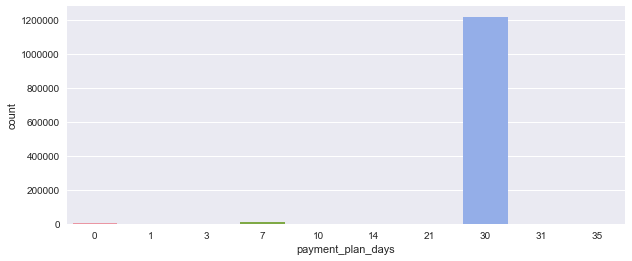

In [24]:
payment_plan_days_var = trans_data[trans_data.payment_plan_days < 45]
sns.countplot(x='payment_plan_days',data=payment_plan_days_var)

Mean decreases a little bit.

### 2.3. Plan Price and Amount Paid
(NO) I add values that are above 210 and add them to "VALUE 130" as the number of instances is very small in comparison.
Finally, I do a bar plot and use only the values below 210.

In [25]:
#trans_data[trans_data.plan_list_price >= 210]
print(trans_data[trans_data.plan_list_price >= 210].shape)

#trans_data[trans_data.actual_amount_paid >= 210]
print(trans_data[trans_data.actual_amount_paid >= 210].shape)

(194430, 10)
(194467, 10)


Approximately, there are around 300 and 700 values that are above 210. Percentage w.r.t. the total: < 1%

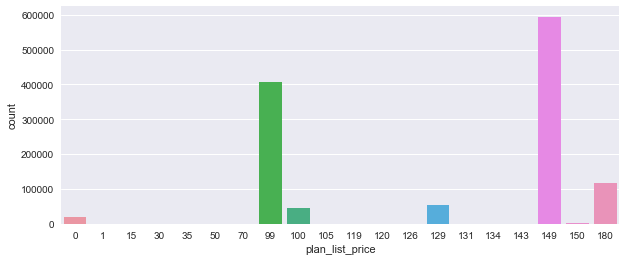

In [26]:
plan_list_price_var = trans_data[trans_data.plan_list_price < 210]
sns.countplot(x='plan_list_price',data=plan_list_price_var)

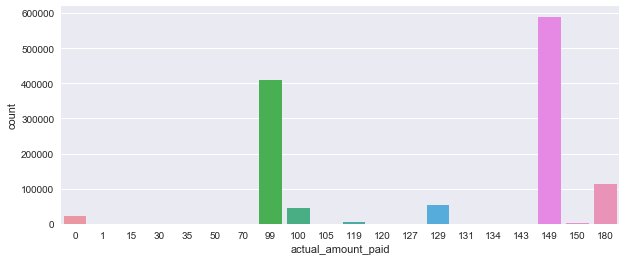

In [27]:
actual_amount_paid_ok = trans_data[trans_data.actual_amount_paid < 210]
sns.countplot(x='actual_amount_paid',data=actual_amount_paid_ok)

### 2.4. Auto renew subscription
It is OK! Only have 0 and 1 values. BUT, sometimes I get other values

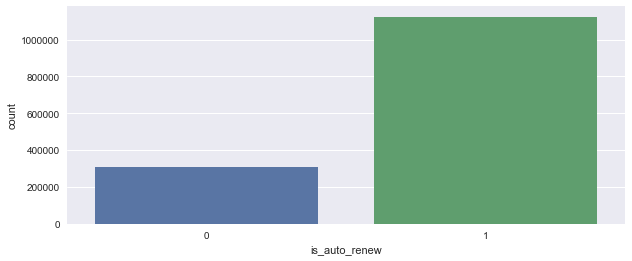

In [28]:
is_auto_renew_var = trans_data[trans_data.is_auto_renew <= 1]
sns.countplot(x='is_auto_renew',data=is_auto_renew_var)

Correlation between plan_list_price and actual_amount_paid

In [29]:
trans_data['plan_list_price'].corr(trans_data['actual_amount_paid'],method='pearson')    

0.9994581971674552

### 1.6. Is Cancel
It is OK! Only have 0 and 1 values. BUT, maybe I get other values

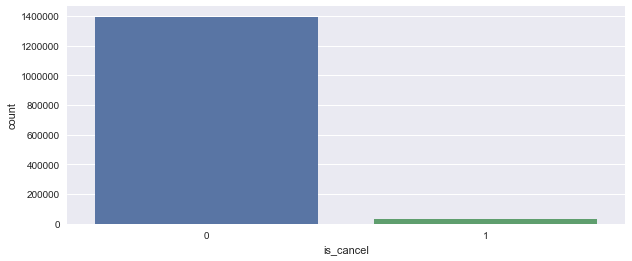

In [30]:
is_cancel_var = trans_data[trans_data.is_cancel <= 1]
sns.countplot(x='is_cancel',data=is_cancel_var)

## 3. Merge with "train.csv"

In [31]:
data1 = pd.read_csv("data/train_v2.csv")

In [32]:
result_dataset = pd.merge(trans_data, data1, on='msno')
result_dataset.head(10)

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,diff_plan_actual,is_churn
0,++lvGPJOinuin/8esghpnqdljm6NXS8m8Zwchc7gOeA=,41,30,149,149,1,2015-08-09,2019-04-12,0,0,0
1,++lvGPJOinuin/8esghpnqdljm6NXS8m8Zwchc7gOeA=,41,30,149,149,1,2015-01-07,2017-06-12,0,0,0
2,++lvGPJOinuin/8esghpnqdljm6NXS8m8Zwchc7gOeA=,41,30,149,149,1,2015-10-09,2019-09-11,0,0,0
3,++lvGPJOinuin/8esghpnqdljm6NXS8m8Zwchc7gOeA=,41,30,149,149,1,2015-02-07,2017-09-10,0,0,0
4,++lvGPJOinuin/8esghpnqdljm6NXS8m8Zwchc7gOeA=,41,30,149,119,1,2015-04-09,2018-05-07,0,30,0
5,++lvGPJOinuin/8esghpnqdljm6NXS8m8Zwchc7gOeA=,41,30,149,149,1,2015-11-09,2019-12-12,0,0,0
6,++lvGPJOinuin/8esghpnqdljm6NXS8m8Zwchc7gOeA=,41,30,149,149,1,2015-01-09,2017-07-13,0,0,0
7,++lvGPJOinuin/8esghpnqdljm6NXS8m8Zwchc7gOeA=,41,0,0,149,1,2015-05-07,2018-06-07,0,-149,0
8,++lvGPJOinuin/8esghpnqdljm6NXS8m8Zwchc7gOeA=,41,0,0,149,1,2015-05-09,2018-08-08,0,-149,0
9,++lvGPJOinuin/8esghpnqdljm6NXS8m8Zwchc7gOeA=,41,30,149,149,1,2015-02-09,2017-10-08,0,0,0


#### Obtain 2 datasets: churned and NOT churned

In [33]:
members_churn_is0 = result_dataset[result_dataset.is_churn == 0] #DataFrame
members_churn_is1 = result_dataset[result_dataset.is_churn == 1] #DataFrame
#members_churn = (result_dataset['is_churn'] == 1) #Series

### 3.1. Payment Method compare to is_Churn

In [34]:
#print(result_dataset.shape) With all the columns
#print(result_dataset['payment_method_id'].shape) #Only the column we want
#idx_churn_1 = (result_dataset['is_churn'] == 1) #A Series
#print(type(idx_churn_1))
#aaa = idx_churn_1[result_dataset.payment_method_id]
#print(aaa)
#print(result_dataset[idx_churn_1].shape)


#idx_churn_1 = (result_dataset['is_churn'] == 1) #I have only the churned users
#idx_churn_1 = (result_dataset['is_churn'] == 1) #I have only the churned users
#idx_churn_1.head()

I will take values above 30 (significant amount of payment method above 30)

visualisation of the percentage of users with payment methods above 30 churning:


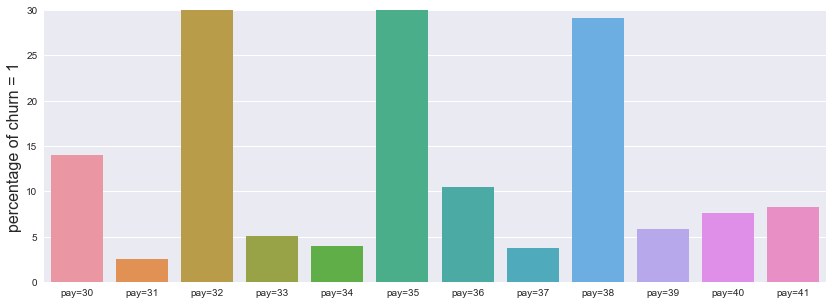

In [35]:
#Percentage of user with payment_method_id = 30 where churn is 1
#print("% of user with payment_method_id = 30 churning (churn = 1)")
perc_30 = 100*members_churn_is1[members_churn_is1.payment_method_id == 30].payment_method_id.count()/result_dataset[result_dataset.payment_method_id == 30].payment_method_id.count()
#print(perc_30)

perc_31 = 100*members_churn_is1[members_churn_is1.payment_method_id == 31].payment_method_id.count()/result_dataset[result_dataset.payment_method_id == 31].payment_method_id.count()
perc_32 = 100*members_churn_is1[members_churn_is1.payment_method_id == 32].payment_method_id.count()/result_dataset[result_dataset.payment_method_id == 32].payment_method_id.count()
perc_33 = 100*members_churn_is1[members_churn_is1.payment_method_id == 33].payment_method_id.count()/result_dataset[result_dataset.payment_method_id == 33].payment_method_id.count()
perc_34 = 100*members_churn_is1[members_churn_is1.payment_method_id == 34].payment_method_id.count()/result_dataset[result_dataset.payment_method_id == 34].payment_method_id.count()
perc_35 = 100*members_churn_is1[members_churn_is1.payment_method_id == 35].payment_method_id.count()/result_dataset[result_dataset.payment_method_id == 35].payment_method_id.count()
perc_36 = 100*members_churn_is1[members_churn_is1.payment_method_id == 36].payment_method_id.count()/result_dataset[result_dataset.payment_method_id == 36].payment_method_id.count()
perc_37 = 100*members_churn_is1[members_churn_is1.payment_method_id == 37].payment_method_id.count()/result_dataset[result_dataset.payment_method_id == 37].payment_method_id.count()
perc_38 = 100*members_churn_is1[members_churn_is1.payment_method_id == 38].payment_method_id.count()/result_dataset[result_dataset.payment_method_id == 38].payment_method_id.count()
perc_39 = 100*members_churn_is1[members_churn_is1.payment_method_id == 39].payment_method_id.count()/result_dataset[result_dataset.payment_method_id == 39].payment_method_id.count()
perc_40 = 100*members_churn_is1[members_churn_is1.payment_method_id == 40].payment_method_id.count()/result_dataset[result_dataset.payment_method_id == 40].payment_method_id.count()

perc_41 = 100*members_churn_is1[members_churn_is1.payment_method_id == 41].payment_method_id.count()/result_dataset[result_dataset.payment_method_id == 41].payment_method_id.count()

p=[perc_30, perc_31, perc_32, perc_33, perc_34, perc_35, perc_36, perc_37, perc_38, perc_39, perc_40, perc_41]
g=["pay=30","pay=31","pay=32","pay=33","pay=34","pay=35","pay=36","pay=37","pay=38","pay=39","pay=40","pay=41"]
print("visualisation of the percentage of users with payment methods above 30 churning:")

plt.figure(figsize=(14,5))
plt.ylim(0, 30)
plt.ylabel('percentage of churn = 1', fontsize=16)
sns.barplot(g,y=p)

### 3.2. Payment plan duration (in days) compare to is_Churn
I will take values below 195 (significant amount of payment method above 30)

/Users/pablodepaz/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in long_scalars
  


visualisation of the percentage of users with days below 195 churning:


/Users/pablodepaz/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in long_scalars
/Users/pablodepaz/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in long_scalars


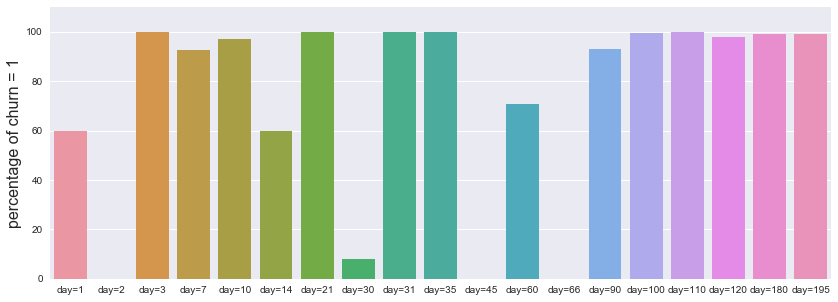

In [36]:
#print("% of user with payment_method_id = 30 churning (churn = 1)")
percent_0 = 100*members_churn_is1[members_churn_is1.payment_plan_days == 0].payment_plan_days.count()/result_dataset[result_dataset.payment_plan_days == 0].payment_plan_days.count()
#print(perc_30)

percent_1 = 100*members_churn_is1[members_churn_is1.payment_plan_days == 1].payment_plan_days.count()/result_dataset[result_dataset.payment_plan_days == 1].payment_plan_days.count()
percent_2 = 100*members_churn_is1[members_churn_is1.payment_plan_days == 2].payment_plan_days.count()/result_dataset[result_dataset.payment_plan_days == 2].payment_plan_days.count()
percent_3 = 100*members_churn_is1[members_churn_is1.payment_plan_days == 3].payment_plan_days.count()/result_dataset[result_dataset.payment_plan_days == 3].payment_plan_days.count()
percent_7 = 100*members_churn_is1[members_churn_is1.payment_plan_days == 7].payment_plan_days.count()/result_dataset[result_dataset.payment_plan_days == 7].payment_plan_days.count()

percent_10 = 100*members_churn_is1[members_churn_is1.payment_plan_days == 10].payment_plan_days.count()/result_dataset[result_dataset.payment_plan_days == 10].payment_plan_days.count()
percent_14 = 100*members_churn_is1[members_churn_is1.payment_plan_days == 14].payment_plan_days.count()/result_dataset[result_dataset.payment_plan_days == 14].payment_plan_days.count()

percent_21 = 100*members_churn_is1[members_churn_is1.payment_plan_days == 21].payment_plan_days.count()/result_dataset[result_dataset.payment_plan_days == 21].payment_plan_days.count()

percent_30 = 100*members_churn_is1[members_churn_is1.payment_plan_days == 30].payment_plan_days.count()/result_dataset[result_dataset.payment_plan_days == 30].payment_plan_days.count()
percent_31 = 100*members_churn_is1[members_churn_is1.payment_plan_days == 31].payment_plan_days.count()/result_dataset[result_dataset.payment_plan_days == 31].payment_plan_days.count()
percent_35 = 100*members_churn_is1[members_churn_is1.payment_plan_days == 35].payment_plan_days.count()/result_dataset[result_dataset.payment_plan_days == 35].payment_plan_days.count()

percent_45 = 100*members_churn_is1[members_churn_is1.payment_plan_days == 45].payment_plan_days.count()/result_dataset[result_dataset.payment_plan_days == 45].payment_plan_days.count()

percent_60 = 100*members_churn_is1[members_churn_is1.payment_plan_days == 60].payment_plan_days.count()/result_dataset[result_dataset.payment_plan_days == 60].payment_plan_days.count()
percent_66 = 100*members_churn_is1[members_churn_is1.payment_plan_days == 66].payment_plan_days.count()/result_dataset[result_dataset.payment_plan_days == 66].payment_plan_days.count()

#percent_70 = 100*members_churn_is1[members_churn_is1.payment_plan_days == 70].payment_plan_days.count()/result_dataset[result_dataset.payment_plan_days == 70].payment_plan_days.count()
#percent_80 = 100*members_churn_is1[members_churn_is1.payment_plan_days == 80].payment_plan_days.count()/result_dataset[result_dataset.payment_plan_days == 80].payment_plan_days.count()

percent_90 = 100*members_churn_is1[members_churn_is1.payment_plan_days == 90].payment_plan_days.count()/result_dataset[result_dataset.payment_plan_days == 90].payment_plan_days.count()
#percent_99 = 100*members_churn_is1[members_churn_is1.payment_plan_days == 99].payment_plan_days.count()/result_dataset[result_dataset.payment_plan_days == 99].payment_plan_days.count()

percent_100 = 100*members_churn_is1[members_churn_is1.payment_plan_days == 100].payment_plan_days.count()/result_dataset[result_dataset.payment_plan_days == 100].payment_plan_days.count()
percent_110 = 100*members_churn_is1[members_churn_is1.payment_plan_days == 110].payment_plan_days.count()/result_dataset[result_dataset.payment_plan_days == 110].payment_plan_days.count()
percent_120 = 100*members_churn_is1[members_churn_is1.payment_plan_days == 120].payment_plan_days.count()/result_dataset[result_dataset.payment_plan_days == 120].payment_plan_days.count()
percent_180 = 100*members_churn_is1[members_churn_is1.payment_plan_days == 180].payment_plan_days.count()/result_dataset[result_dataset.payment_plan_days == 180].payment_plan_days.count()
percent_195 = 100*members_churn_is1[members_churn_is1.payment_plan_days == 195].payment_plan_days.count()/result_dataset[result_dataset.payment_plan_days == 195].payment_plan_days.count()


p=[percent_1, percent_2, percent_3, percent_7, percent_10, percent_14, percent_21, percent_30, percent_31, percent_35, percent_45, percent_60, percent_66, percent_90, percent_100, percent_110, percent_120, percent_180, percent_195]
g=["day=1","day=2","day=3","day=7","day=10","day=14","day=21","day=30","day=31","day=35","day=45","day=60","day=66","day=90","day=100","day=110","day=120","day=180","day=195"]
print("visualisation of the percentage of users with days below 195 churning:")

plt.figure(figsize=(14,5))
plt.ylim(0, 110)
plt.ylabel('percentage of churn = 1', fontsize=16)
sns.barplot(g,y=p)

### 3.3.Plan Price and Amount Paid compare to is_Churn
I will just take values 0, 99, 100, 129, 149 (the largest), 150, 180.

visualisation of the percentage of users with days below 195 churning:


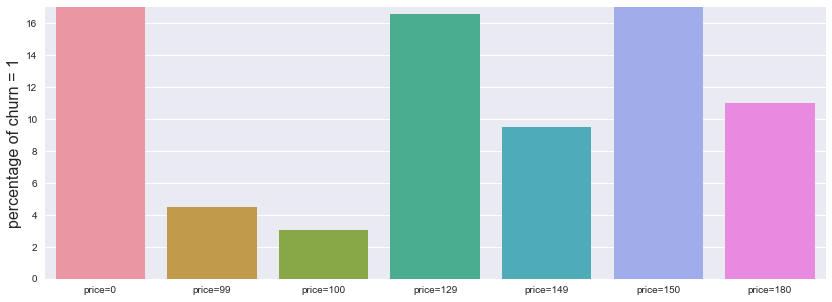

In [37]:
p_0 = 100*members_churn_is1[members_churn_is1.plan_list_price == 0].plan_list_price.count()/result_dataset[result_dataset.plan_list_price == 0].plan_list_price.count()
p_99 = 100*members_churn_is1[members_churn_is1.plan_list_price == 99].plan_list_price.count()/result_dataset[result_dataset.plan_list_price == 99].plan_list_price.count()
p_100 = 100*members_churn_is1[members_churn_is1.plan_list_price == 100].plan_list_price.count()/result_dataset[result_dataset.plan_list_price == 100].plan_list_price.count()
p_129 = 100*members_churn_is1[members_churn_is1.plan_list_price == 129].plan_list_price.count()/result_dataset[result_dataset.plan_list_price == 129].plan_list_price.count()
p_149 = 100*members_churn_is1[members_churn_is1.plan_list_price == 149].plan_list_price.count()/result_dataset[result_dataset.plan_list_price == 149].plan_list_price.count()
p_150 = 100*members_churn_is1[members_churn_is1.plan_list_price == 150].plan_list_price.count()/result_dataset[result_dataset.plan_list_price == 150].plan_list_price.count()
p_180 = 100*members_churn_is1[members_churn_is1.plan_list_price == 180].plan_list_price.count()/result_dataset[result_dataset.plan_list_price == 180].plan_list_price.count()

p=[p_0, p_99,p_100,p_129,p_149,p_150,p_180]
g=["price=0","price=99","price=100","price=129","price=149","price=150","price=180"]
print("visualisation of the percentage of users with days below 195 churning:")

plt.figure(figsize=(14,5))
plt.ylim(0, 17)
plt.ylabel('percentage of churn = 1', fontsize=16)
sns.barplot(g,y=p)


### 3.4. is_auto_renew compare to is_Churn

% of user with auto_renew = 1 churning (churn=1)
7.654494517423353
% of user with auto_renew = 0 churning (churn=1)
36.06754617414248
visualisation of the percentage of users with auto_renew 1 and auto_renew 0 churning:


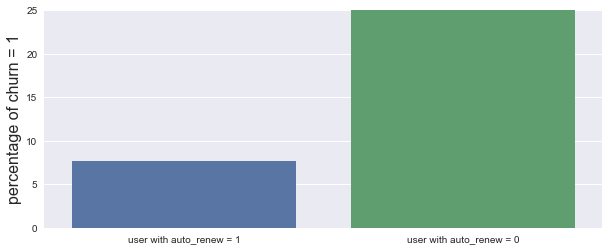

In [38]:
#Percentage of user with auto_renew = 1 where churn is 1
print("% of user with auto_renew = 1 churning (churn=1)")
perc_1 = 100*members_churn_is1[members_churn_is1.is_auto_renew == 1].is_auto_renew.count()/result_dataset[result_dataset.is_auto_renew == 1].is_auto_renew.count()
print(perc_1)

#percentage of user with auto_renew = 0 where churn is 1
print("% of user with auto_renew = 0 churning (churn=1)")
perc_0 = 100*members_churn_is1[members_churn_is1.is_auto_renew == 0].is_auto_renew.count()/result_dataset[result_dataset.is_auto_renew == 0].is_auto_renew.count()
print(perc_0)

p=[perc_1,perc_0]
g=["user with auto_renew = 1","user with auto_renew = 0"]
print("visualisation of the percentage of users with auto_renew 1 and auto_renew 0 churning:")

plt.ylim(0, 25)
plt.ylabel('percentage of churn = 1', fontsize=16)
sns.barplot(g,y=p)

### 3.6. is_cancel compare to is_Churn

% of user with is_cancel = 1 churning (churn=1)
59.57485630873096
% of user with is_cancel = 0 churning (churn=1)
8.550492970496373
visualisation of the percentage of users with is_cancel 1 and is_cancel 0 churning:


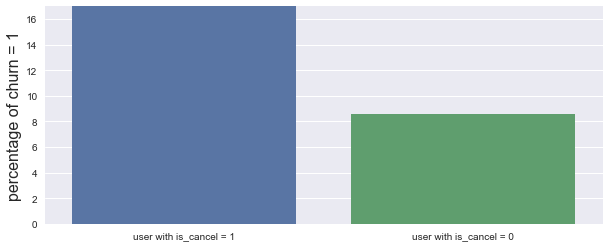

In [39]:
#Percentage of user with is_cancel = 1 where churn is 1
print("% of user with is_cancel = 1 churning (churn=1)")
perc_1 = 100*members_churn_is1[members_churn_is1.is_cancel == 1].is_cancel.count()/result_dataset[result_dataset.is_cancel == 1].is_cancel.count()
print(perc_1)

#percentage of user with is_cancel = 0 where churn is 1
print("% of user with is_cancel = 0 churning (churn=1)")
perc_0 = 100*members_churn_is1[members_churn_is1.is_cancel == 0].is_cancel.count()/result_dataset[result_dataset.is_cancel == 0].is_cancel.count()
print(perc_0)

p=[perc_1,perc_0]
g=["user with is_cancel = 1","user with is_cancel = 0"]
print("visualisation of the percentage of users with is_cancel 1 and is_cancel 0 churning:")

plt.ylim(0, 17)
plt.ylabel('percentage of churn = 1', fontsize=16)
sns.barplot(g,y=p)

## 4. FEATURE ENGINEERING
I will do feature engineering in a new dataset, to be merged later in STEP 5 to check the algorithm.

In [40]:
train = pd.read_csv("data/train_v2.csv")
test = pd.read_csv('data/sample_submission_v2.csv')
print(trans_data.shape)
print(trans_data.info())
print(trans_data.describe())

(1431009, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1431009 entries, 0 to 1431008
Data columns (total 10 columns):
msno                      1431009 non-null object
payment_method_id         1431009 non-null int64
payment_plan_days         1431009 non-null int64
plan_list_price           1431009 non-null int64
actual_amount_paid        1431009 non-null int64
is_auto_renew             1431009 non-null int64
transaction_date          1431009 non-null object
membership_expire_date    1431009 non-null object
is_cancel                 1431009 non-null int64
diff_plan_actual          1431009 non-null int64
dtypes: int64(7), object(3)
memory usage: 109.2+ MB
None
       payment_method_id  payment_plan_days  plan_list_price  \
count       1.431009e+06       1.431009e+06     1.431009e+06   
mean        3.791835e+01       6.601770e+01     2.817870e+02   
std         4.964805e+00       1.024864e+02     4.351861e+02   
min         2.000000e+00       0.000000e+00     0.000000e+00   
25%

### Feature 1 : discount
I create a discount column to see how much discount was offered to the customer.

In [41]:
result_dataset['discount'] = result_dataset['plan_list_price'] - result_dataset['actual_amount_paid']

result_dataset['discount'].unique() #Find the unique elements of an array/dataset

array([   0,   30, -149, -129,  180, -119,  149,   50,   99, -100,   20,
         -1,  129,  120, 1599,    1])

### Feature 2 : is_discount
Feature to check whether the customer has availed any discount or not

In [42]:
result_dataset['is_discount'] = result_dataset.discount.apply(lambda x: 1 if x > 0 else 0)
print(result_dataset['is_discount'].head())
print(result_dataset['is_discount'].unique())

0    0
1    0
2    0
3    0
4    1
Name: is_discount, dtype: int64
[0 1]


### Feature 3 : amount_per_day
Division between "actual_amount_paid" and "payment_plan_days"

In [43]:
result_dataset['amt_per_day'] = result_dataset['actual_amount_paid'] / result_dataset['payment_plan_days']
result_dataset['amt_per_day'].head()

0    4.966667
1    4.966667
2    4.966667
3    4.966667
4    3.966667
Name: amt_per_day, dtype: float64

It seems that I get "infinite" in some values or "amount_per_day". This is probably because "payment_plan_days" is 0.

### Feature 4: membership duration
Difference between **transaction_date** and **membership_expire_date**. We find the difference in terms of days and months. We keep this result as _integer_.

In [44]:
#--- difference in days ---
result_dataset['membership_duration'] = result_dataset.membership_expire_date - result_dataset.transaction_date
result_dataset['membership_duration'] = result_dataset['membership_duration'] / np.timedelta64(1, 'D')
result_dataset['membership_duration'] = result_dataset['membership_duration'].astype(int)

 
#---difference in months ---
#df_transactions['membership_duration_M'] = (df_transactions.membership_expire_date - df_transactions.transaction_date)/ np.timedelta64(1, 'M')
#df_transactions['membership_duration_M'] = round(df_transactions['membership_duration_M']).astype(int)
#df_transactions['membership_duration_M'].head()

In [45]:
#Check columns now
len(result_dataset.columns)
result_dataset.head()

,msno,payment_method_id,payment_plan_days,plan_list_price,actual_amount_paid,is_auto_renew,transaction_date,membership_expire_date,is_cancel,diff_plan_actual,is_churn,discount,is_discount,amt_per_day,membership_duration
0,++lvGPJOinuin/8esghpnqdljm6NXS8m8Zwchc7gOeA=,41,30,149,149,1,2015-08-09,2019-04-12,0,0,0,0,0,4.966667,1342
1,++lvGPJOinuin/8esghpnqdljm6NXS8m8Zwchc7gOeA=,41,30,149,149,1,2015-01-07,2017-06-12,0,0,0,0,0,4.966667,887
2,++lvGPJOinuin/8esghpnqdljm6NXS8m8Zwchc7gOeA=,41,30,149,149,1,2015-10-09,2019-09-11,0,0,0,0,0,4.966667,1433
3,++lvGPJOinuin/8esghpnqdljm6NXS8m8Zwchc7gOeA=,41,30,149,149,1,2015-02-07,2017-09-10,0,0,0,0,0,4.966667,946
4,++lvGPJOinuin/8esghpnqdljm6NXS8m8Zwchc7gOeA=,41,30,149,119,1,2015-04-09,2018-05-07,0,30,0,30,1,3.966667,1124


In [46]:
print(result_dataset.describe())

       payment_method_id  payment_plan_days  plan_list_price  \
count       1.132036e+06       1.132036e+06     1.132036e+06   
mean        3.887682e+01       3.356030e+01     1.455336e+02   
std         3.877857e+00       3.179832e+01     1.331882e+02   
min         3.000000e+00       0.000000e+00     0.000000e+00   
25%         3.800000e+01       3.000000e+01     9.900000e+01   
50%         4.100000e+01       3.000000e+01     1.490000e+02   
75%         4.100000e+01       3.000000e+01     1.490000e+02   
max         4.100000e+01       4.500000e+02     2.000000e+03   

       actual_amount_paid  is_auto_renew     is_cancel  diff_plan_actual  \
count        1.132036e+06   1.132036e+06  1.132036e+06      1.132036e+06   
mean         1.450239e+02   9.163012e-01  2.904766e-02      5.097108e-01   
std          1.333376e+02   2.769356e-01  1.679402e-01      1.224728e+01   
min          0.000000e+00   0.000000e+00  0.000000e+00     -1.490000e+02   
25%          9.900000e+01   1.000000e+00  0


## 5. XGBoost testing
I will try the **result_dataset** with XGBoost. 

### 5.1. Merge the datasets according to the User ID (msno)